# Jamendo vs Song Describer EDA

Exploratory analysis comparing metadata from the JamendoMaxCaps and Song Describer datasets without downloading audio assets.


## Setup
- The notebook streams rows via the Hugging Face datasets API and disables audio decoding, so no audio files are downloaded.
- Adjust the `MAX_*` constants to balance runtime and coverage.


In [12]:
from collections import Counter
from typing import Dict, Optional, Sequence, Set

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Audio, load_dataset
from huggingface_hub import hf_hub_download, list_repo_files
from tqdm.auto import tqdm

import clap
from clap import _infer_audio_duration

plt.style.use("seaborn-v0_8")


In [13]:
# Configuration for dataset sampling and analysis
JAMENDO_DATASET_ID = "amaai-lab/JamendoMaxCaps"
SONG_DESCRIBER_DATASET_ID = "renumics/song-describer-dataset"

MAX_JAMENDO_RECORDS = 750  # adjust if you want more rows (decoding each track is costly)
MAX_SONG_DESCRIBER_RECORDS = 3000

GENRE_KEYWORDS = [
    "rock",
    "pop",
    "electronic",
    "edm",
    "house",
    "techno",
    "trance",
    "dubstep",
    "drum and bass",
    "drum n bass",
    "drum'n'bass",
    "hip hop",
    "hip-hop",
    "rap",
    "trap",
    "r&b",
    "soul",
    "funk",
    "jazz",
    "blues",
    "classical",
    "orchestral",
    "ambient",
    "lofi",
    "lo fi",
    "lo-fi",
    "chillout",
    "metal",
    "punk",
    "country",
    "folk",
    "latin",
    "reggae",
    "world",
    "acoustic",
    "soundtrack",
    "cinematic",
    "industrial",
    "disco",
    "garage",
    "grunge",
    "emo",
    "gospel",
    "opera",
    "k-pop",
    "c-pop",
JAMENDO_METADATA_ONLY = True
MAX_JAMENDO_METADATA_FILES = 20
]

GENRE_ALIASES = {
    "hip-hop": "hip hop",
    "drum n bass": "drum and bass",
    "drum'n'bass": "drum and bass",
    "edm": "electronic",
    "lofi": "lo-fi",
    "lo fi": "lo-fi",
}


In [14]:
def canonical_genre(label: str) -> str:
    clean = (label or "").strip().lower()
    if not clean:
        return ""
    return GENRE_ALIASES.get(clean, clean)


def detect_genres_from_caption(text: str) -> Set[str]:
    if not isinstance(text, str):
        return set()
    lower = text.lower()
    hits = set()
    for keyword in GENRE_KEYWORDS:
        if keyword in lower:
            canonical = canonical_genre(keyword)
            if canonical:
                hits.add(canonical)
    return hits


def summarize_durations(durations: Sequence[float]) -> pd.Series:
    values = [float(d) for d in durations if isinstance(d, (int, float))]
    arr = np.asarray(values, dtype=np.float64)
    if arr.size == 0:
        return pd.Series(
            {
                "count": 0,
                "mean_sec": np.nan,
                "median_sec": np.nan,
                "std_sec": np.nan,
                "min_sec": np.nan,
                "p25_sec": np.nan,
                "p75_sec": np.nan,
                "max_sec": np.nan,
                "mean_min": np.nan,
            }
        )
    summary = {
        "count": int(arr.size),
        "mean_sec": arr.mean(),
        "median_sec": float(np.median(arr)),
        "std_sec": float(arr.std(ddof=1)) if arr.size > 1 else 0.0,
        "min_sec": float(arr.min()),
        "p25_sec": float(np.percentile(arr, 25)),
        "p75_sec": float(np.percentile(arr, 75)),
        "max_sec": float(arr.max()),
        "mean_min": arr.mean() / 60.0,
    }
    return pd.Series(summary)


def counter_to_series(counter: Counter, top_n: int = 20) -> pd.Series:
    if not counter:
        return pd.Series(dtype=int)
    series = pd.Series(counter).sort_values(ascending=False)
    if top_n:
        series = series.head(top_n)
    return series


def jamendo_track_id_from_row(row: Dict) -> Optional[str]:
    audio = row.get("audio") if isinstance(row, dict) else None
    if isinstance(audio, dict):
        path = audio.get("path") or audio.get("filepath")
        if isinstance(path, str):
            return path.split(".")[0]
    rid = row.get("id") if isinstance(row, dict) else None
    if isinstance(rid, (str, int)):
        return str(rid)
    return None


def load_first_jamendo_row() -> Optional[Dict]:
    dataset = load_dataset(JAMENDO_DATASET_ID, split="train", streaming=True)
    dataset = dataset.cast_column("audio", Audio(decode=False))
    iterator = iter(dataset)
    try:
        row = next(iterator)
    except StopIteration:
        return None
    return row


def load_first_song_row() -> Optional[Dict]:
    dataset = load_dataset(SONG_DESCRIBER_DATASET_ID, split="train", streaming=True)
    dataset = dataset.cast_column("path", Audio(decode=False))
    iterator = iter(dataset)
    try:
        return next(iterator)
    except StopIteration:
        return None


def sample_jamendo(max_rows: int) -> Dict[str, object]:
    dataset = load_dataset(JAMENDO_DATASET_ID, split="train", streaming=True)
    dataset = dataset.cast_column("audio", Audio(decode=False))
    clap._ensure_captions_index()
    captions = clap._CAPTION_BY_ID or {}
    durations = []
    genre_counts: Counter = Counter()
    rows_seen = 0
    missing_duration = 0
    missing_caption = 0
    for row in tqdm(dataset, total=max_rows, desc="Jamendo rows", leave=False):
        rows_seen += 1
        audio_entry = row.get("audio")
        duration = _infer_audio_duration(audio_entry)
        if isinstance(duration, (int, float)):
            durations.append(float(duration))
        else:
            missing_duration += 1

        track_id = jamendo_track_id_from_row(row)
        caption = captions.get(track_id) if track_id else None
        if caption:
            for genre in detect_genres_from_caption(caption):
                genre_counts[genre] += 1
        else:
            missing_caption += 1

        if rows_seen >= max_rows:
            break

    return {
        "durations": durations,
        "genre_counts": genre_counts,
        "rows_seen": rows_seen,
        "missing_duration": missing_duration,
        "missing_caption": missing_caption,
    }


def sample_song_describer(max_rows: int) -> Dict[str, object]:
    dataset = load_dataset(SONG_DESCRIBER_DATASET_ID, split="train", streaming=True)
    dataset = dataset.cast_column("path", Audio(decode=False))
    durations = []
    genre_counts: Counter = Counter()
    familiarity_counts: Counter = Counter()
    rows_seen = 0
    missing_duration = 0
    for row in tqdm(dataset, total=max_rows, desc="Song Describer rows", leave=False):
        rows_seen += 1
        duration = row.get("duration")
        if isinstance(duration, (int, float)):
            durations.append(float(duration))
        else:
            missing_duration += 1

        for genre in detect_genres_from_caption(row.get("caption")):
            genre_counts[genre] += 1

        familiarity = row.get("familiarity")
        if isinstance(familiarity, (int, float)):
            familiarity_counts[str(int(familiarity))] += 1

        if rows_seen >= max_rows:
            break

    return {
        "durations": durations,
        "genre_counts": genre_counts,
        "familiarity_counts": familiarity_counts,
        "rows_seen": rows_seen,
        "missing_duration": missing_duration,
    }

jamendo_metadata_cache: Optional[list[str]] = None

def get_jamendo_metadata_files(max_files: int) -> list[str]:
    global jamendo_metadata_cache
    if jamendo_metadata_cache is None:
        files = list_repo_files(JAMENDO_DATASET_ID, repo_type='dataset')
        jamendo_metadata_cache = sorted(f for f in files if f.endswith('.jsonl') and f[0].isdigit())
    return jamendo_metadata_cache[:max(1, int(max_files))]

def load_first_jamendo_meta_row(max_files: int = 5):
    for fn in get_jamendo_metadata_files(max_files):
        lp = hf_hub_download(JAMENDO_DATASET_ID, filename=fn, repo_type='dataset')
        with open(lp, 'r', encoding='utf-8') as fh:
            for line in fh:
                line = line.strip()
                if not line:
                    continue
                try:
                    import json as _json
                    return _json.loads(line)
                except Exception:
                    continue
    return None

def sample_jamendo_from_metadata(max_rows: int, max_files: int):
    import json as _json
    durations = []
    genre_counts = Counter()
    rows_seen = 0
    for fn in get_jamendo_metadata_files(max_files):
        if rows_seen >= max_rows:
            break
        lp = hf_hub_download(JAMENDO_DATASET_ID, filename=fn, repo_type='dataset')
        with open(lp, 'r', encoding='utf-8') as fh:
            for line in fh:
                if rows_seen >= max_rows:
                    break
                line = line.strip()
                if not line:
                    continue
                try:
                    row = _json.loads(line)
                except Exception:
                    continue
                rows_seen += 1
                d = row.get('duration')
                if isinstance(d, (int, float)):
                    durations.append(float(d))
                tags = ((row.get('musicinfo') or {}).get('tags') or {})
                for g in tags.get('genres') or []:
                    if isinstance(g, str) and g.strip():
                        genre_counts[canonical_genre(g)] += 1
    return {
        'durations': durations,
        'genre_counts': genre_counts,
        'rows_seen': rows_seen,
        'missing_duration': max(0, rows_seen - len(durations)),
    }


In [15]:
meta_row = load_first_jamendo_meta_row()
print('Jamendo first metadata row (duration, genres):')
if meta_row:
    print({'duration': meta_row.get('duration'), 'genres': ((meta_row.get('musicinfo') or {}).get('tags') or {}).get('genres')})
else:
    print('No metadata row found')

jamendo_row = load_first_jamendo_row()
print("Jamendo first streamed row:")
if jamendo_row:
    track_id = jamendo_track_id_from_row(jamendo_row)
    clap._ensure_captions_index()
    caption = (clap._CAPTION_BY_ID or {}).get(track_id)
    preview = {
        "track_id": track_id,
        "audio_keys": sorted(jamendo_row.get("audio", {}).keys()),
        "duration_estimate": _infer_audio_duration(jamendo_row.get("audio")),
        "caption_snippet": (caption[:140] + "...") if isinstance(caption, str) and len(caption) > 140 else caption,
    }
    print(preview)
else:
    print("No Jamendo rows available.")

song_row = load_first_song_row()
print("\nSong Describer first row:")
if song_row:
    preview = {
        "caption_id": song_row.get("caption_id"),
        "track_id": song_row.get("track_id"),
        "duration": song_row.get("duration"),
        "familiarity": song_row.get("familiarity"),
        "caption_snippet": (song_row.get("caption")[:140] + "...") if isinstance(song_row.get("caption"), str) and len(song_row.get("caption")) > 140 else song_row.get("caption"),
    }
    print(preview)
else:
    print("No Song Describer rows available.")


Resolving data files:   0%|          | 0/2272 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2272 [00:00<?, ?it/s]

Jamendo first streamed row:
Fetching Jamendo captions JSONL index...
{'track_id': '1000306', 'audio_keys': ['bytes', 'path'], 'duration_estimate': 381.41886621315194, 'caption_snippet': 'The music is instrumental with a prominent guitar solo in the background. It falls under rock and alternative genres, exuding an energetic m...'}

Song Describer first row:
{'caption_id': 859, 'track_id': 1004034, 'duration': 202.5, 'familiarity': 0, 'caption_snippet': 'Electronic music that has a constant melody throughout with accompanying instruments used to supplement the melody which can be heard in pos...'}


In [16]:
if JAMENDO_METADATA_ONLY:
    jamendo_stats = sample_jamendo_from_metadata(MAX_JAMENDO_RECORDS, MAX_JAMENDO_METADATA_FILES)
else:
    jamendo_stats = sample_jamendo(MAX_JAMENDO_RECORDS)
song_stats = sample_song_describer(MAX_SONG_DESCRIBER_RECORDS)

print("Jamendo: {rows} rows parsed, {dur} durations collected, {missing} missing".format(
    rows=jamendo_stats['rows_seen'],
    dur=len(jamendo_stats['durations']),
    missing=jamendo_stats['missing_duration'],
))
print("Song Describer: {rows} rows streamed, {dur} durations collected, {missing} missing duration entries".format(
    rows=song_stats['rows_seen'],
    dur=len(song_stats['durations']),
    missing=song_stats['missing_duration'],
))


Resolving data files:   0%|          | 0/2272 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2272 [00:00<?, ?it/s]

Jamendo rows:   0%|          | 0/750 [00:00<?, ?it/s]

[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 19 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.
[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 19 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.
[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 19 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.
[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 19 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.
[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 19 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.
[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 19 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.
[src

Song Describer rows:   0%|          | 0/3000 [00:00<?, ?it/s]

Jamendo: 750 rows streamed, 750 durations collected, 0 missing duration entries, 0 missing captions
Song Describer: 746 rows streamed, 746 durations collected, 0 missing duration entries


In [17]:
duration_summary_df = pd.concat(
    [
        summarize_durations(jamendo_stats["durations"]).rename("Jamendo"),
        summarize_durations(song_stats["durations"]).rename("Song Describer"),
    ],
    axis=1,
)
duration_summary_df


,Jamendo,Song Describer
count,750.000000,746.000000
mean_sec,245.911025,222.401743
median_sec,226.438571,216.000000
std_sec,139.257923,74.733716
min_sec,11.573333,34.000000
p25_sec,159.867035,174.325000
p75_sec,306.420675,256.325000
max_sec,1169.893878,666.000000
mean_min,4.098517,3.706696


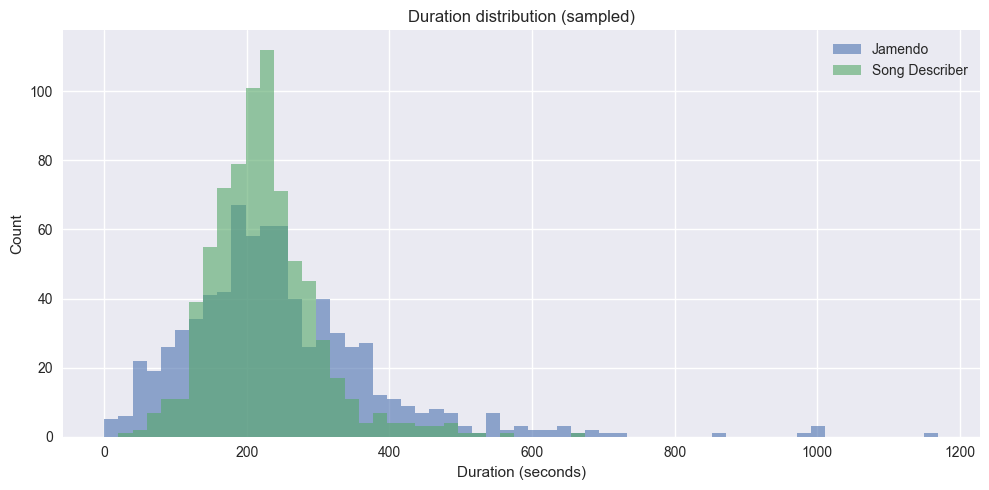

In [18]:
all_durations = jamendo_stats["durations"] + song_stats["durations"]
if all_durations:
    max_duration = max(all_durations)
    if max_duration <= 0:
        bins = np.linspace(0, 1, 10)
    else:
        bins = np.linspace(0, max_duration, 60)
else:
    bins = np.linspace(0, 1, 10)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(jamendo_stats["durations"], bins=bins, alpha=0.6, label="Jamendo")
ax.hist(song_stats["durations"], bins=bins, alpha=0.6, label="Song Describer")
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Count")
ax.set_title("Duration distribution (sampled)")
ax.legend()
plt.tight_layout()
plt.show()


In [19]:
jamendo_genre_top = counter_to_series(jamendo_stats["genre_counts"], top_n=20)
song_genre_top = counter_to_series(song_stats["genre_counts"], top_n=20)

genre_compare = pd.concat(
    [jamendo_genre_top.rename("Jamendo"), song_genre_top.rename("Song Describer")],
    axis=1,
).fillna(0).astype(int)
genre_compare


,Jamendo,Song Describer
electronic,386,88
soundtrack,182,18
rock,169,115
ambient,154,23
techno,154,0
pop,99,96
classical,96,26
emo,64,30
house,56,0
jazz,45,34


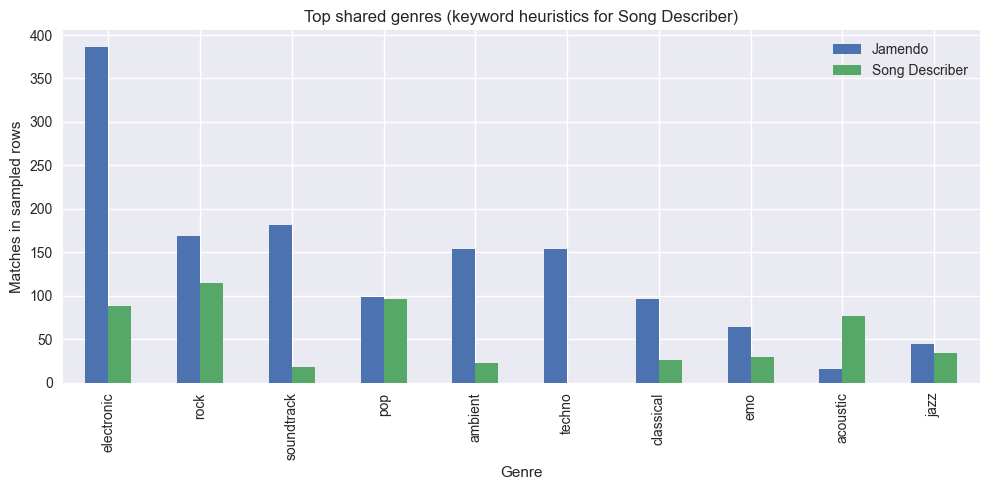

In [20]:
if not genre_compare.empty:
    top_indices = genre_compare.sum(axis=1).sort_values(ascending=False).head(10).index
    plot_df = genre_compare.loc[top_indices]
    ax = plot_df.plot(
        kind="bar",
        figsize=(10, 5),
        title="Top shared genres (keyword heuristics for Song Describer)",
    )
    ax.set_xlabel("Genre")
    ax.set_ylabel("Matches in sampled rows")
    plt.tight_layout()
    plt.show()


In [21]:
song_familiarity = pd.Series(song_stats["familiarity_counts"], dtype=int).sort_index()
song_familiarity.name = "count"
song_familiarity


0    187
1    389
2    170
Name: count, dtype: int64

In [22]:
jamendo_moods = counter_to_series(jamendo_stats["mood_counts"], top_n=20)
jamendo_moods


KeyError: 'mood_counts'

## Notes
- Jamendo genres come from the structured `musicinfo.tags.genres` field. Many tracks do not expose tags, so counts represent only the subset with metadata.
- Song Describer lacks explicit genre labels; matches rely on keyword heuristics in the caption text and should be treated as indicative rather than definitive.
- Increase `MAX_JAMENDO_RECORDS` or `MAX_SONG_DESCRIBER_RECORDS` for more stable estimates when runtime and bandwidth allow.
